# ¿Cuál es la mejor tarifa?

Trabajas como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Vas a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. Tu trabajo es analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

## Inicialización

In [1]:
# Cargar todas las librerías
from scipy import stats as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math 


## Cargar datos

In [2]:
# Carga los archivos de datos en diferentes DataFrames

df_calls = pd.read_csv('megaline_calls.csv')

df_internet = pd.read_csv('megaline_internet.csv')

df_messages = pd.read_csv('megaline_messages.csv')

df_plans = pd.read_csv('megaline_plans.csv')

df_users = pd.read_csv('megaline_users.csv')


## Preparar los datos

## Tarifas

In [3]:
# Imprime la información general/resumida sobre el DataFrame de las tarifas

df_plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 260.0+ bytes


In [4]:
# Imprime una muestra de los datos para las tarifas
df_plans.head()


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


Los datos en la tabla estan en un formato correcto, hay 5 columnas con numeros enteros y 2 con numeros flotantes, ademas de la columna de los planes con datos object

## Corregir datos

In [5]:
# cambio de la columna mb per month a gb per month

df_plans = df_plans.rename(columns={'mb_per_month_included': 'gb_per_month_included'})

df_plans['gb_per_month_included'] = df_plans['gb_per_month_included']/1024
 
df_plans.head()


,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15.0,500,20,10,0.03,0.03,surf
1,1000,30.0,3000,70,7,0.01,0.01,ultimate


## Enriquecer los datos

En el codigo anterior se modificó la columna de mb per month dividiendola entre 1024 y cambiando su nombre para obtener los gb per month

## Usuarios/as

In [6]:
# Imprime la información general/resumida sobre el DataFrame de usuarios

df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [7]:
# Imprime una muestra de datos para usuarios
df_users.head()


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


En este dataframe, hay datos tipo object y para la edad es tipo int, en la colunma churn date, existen datos faltantes, sin embargo es correcto por que contiene la fecha para los usuarios que han dejado de usar el servicio.


## Llamadas

In [8]:
# Imprimir la información general/resumida sobre el DataFrame de las llamadas
df_calls.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [9]:
# Imprimir una muestra de datos para las llamadas

df_calls.head()


,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


### Corregir los datos

In [10]:
# Formatear la fecha
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'],format='%Y-%m-%d')
df_calls.info()
df_calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB


,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


### Enriquecer los datos

### Encontrar las llamadas no respondidas

In [11]:
# Llamadas con duracion de 0
print(df_calls[df_calls['duration'] ==0])

              id  user_id  call_date  duration
19        1001_4     1001 2018-12-05       0.0
25       1001_13     1001 2018-12-24       0.0
31       1001_30     1001 2018-10-17       0.0
32       1001_31     1001 2018-11-03       0.0
34       1001_35     1001 2018-12-21       0.0
...          ...      ...        ...       ...
137714  1499_183     1499 2018-11-10       0.0
137715  1499_184     1499 2018-09-15       0.0
137720  1499_189     1499 2018-12-27       0.0
137722  1499_191     1499 2018-12-24       0.0
137725  1499_194     1499 2018-10-31       0.0

[26834 rows x 4 columns]


Existen 26834 llamadas con una duracion de 0, esto puede significarse que las llamadas no fueron respondidas

## Mensajes

In [12]:
# Imprimir la información general/resumida sobre el DataFrame de los mensajes
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [13]:
# Imprimir una muestra de datos para los mensajes

df_messages.head()

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


* En esta tabla cambiaremos message_date a tipo datetime

### Corregir los datos

In [14]:
# Formatear la fecha
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format = '%Y-%m-%d')
df_messages.info()
df_messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


## Internet

In [15]:
# Imprimir la información general/resumida sobre el DataFrame de internet

df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [16]:
# Imprimir una muestra de datos para el tráfico de internet
df_internet.head()


,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


La columna session_date la convertiremos a tipo datetime

### Corregir los datos

In [17]:
# Formatear la fecha 
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format = '%Y-%m-%d')
df_internet.info()
df_internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB


,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


### Enriquecer los datos

In [18]:
# Transformacion y cambio de nombre de la columna mb_used a gb_used y redondeo hacia arriba con math.ceil
df_internet.rename(columns={'mb_used':'gb_used'}, inplace = True)

df_internet['gb_used'] = (df_internet['gb_used']/1024).apply(math.ceil)

df_internet['gb_used'].head()

0    1
1    0
2    1
3    1
4    1
Name: gb_used, dtype: int64

## Estudiar las condiciones de las tarifas

In [19]:
# Imprime las condiciones de la tarifa 
df_plans.head()



,messages_included,gb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15.0,500,20,10,0.03,0.03,surf
1,1000,30.0,3000,70,7,0.01,0.01,ultimate


In [20]:
# Calcular el número de llamadas hechas por cada usuario al mes.

df_calls['year_month'] = df_calls['call_date'].dt.to_period('M')

calls_per_user = df_calls.groupby(['user_id', 'year_month']).size().reset_index(name='call_count')

print(calls_per_user)


      user_id year_month  call_count
0        1000    2018-12          16
1        1001    2018-08          27
2        1001    2018-09          49
3        1001    2018-10          65
4        1001    2018-11          64
...       ...        ...         ...
2253     1498    2018-12          39
2254     1499    2018-09          41
2255     1499    2018-10          53
2256     1499    2018-11          45
2257     1499    2018-12          65

[2258 rows x 3 columns]


In [21]:
# Mostrar tabla con numero de minutos y llamadas en el mes
pivot_calls = df_calls.pivot_table(index=['user_id', 'year_month'],
                            values=['duration'],
                            aggfunc=['sum','count']).reset_index()
print(pivot_calls)

     user_id year_month      sum    count
                        duration duration
0       1000    2018-12   116.83       16
1       1001    2018-08   171.14       27
2       1001    2018-09   297.69       49
3       1001    2018-10   374.11       65
4       1001    2018-11   404.59       64
...      ...        ...      ...      ...
2253    1498    2018-12   324.77       39
2254    1499    2018-09   330.37       41
2255    1499    2018-10   363.28       53
2256    1499    2018-11   288.56       45
2257    1499    2018-12   468.10       65

[2258 rows x 4 columns]


In [22]:
# Calcular la cantidad de minutos usados por cada usuario al mes. 
#Rendondeo de el total de minutos por llamada

minutes_per_user = df_calls.groupby(['user_id', 'year_month'])['duration'].sum().reset_index(name='total_minutes')

minutes_per_user['total_minutes'] = minutes_per_user['total_minutes'].apply(math.ceil)
print(minutes_per_user)


      user_id year_month  total_minutes
0        1000    2018-12            117
1        1001    2018-08            172
2        1001    2018-09            298
3        1001    2018-10            375
4        1001    2018-11            405
...       ...        ...            ...
2253     1498    2018-12            325
2254     1499    2018-09            331
2255     1499    2018-10            364
2256     1499    2018-11            289
2257     1499    2018-12            469

[2258 rows x 3 columns]


In [23]:
# Calcular el número de mensajes enviados por cada usuario al mes. 

df_messages['year_month'] = df_messages['message_date'].dt.to_period('M')

msg_per_user = df_messages.groupby(['user_id', 'year_month']).size().reset_index(name='message_count')

print(msg_per_user)

      user_id year_month  message_count
0        1000    2018-12             11
1        1001    2018-08             30
2        1001    2018-09             44
3        1001    2018-10             53
4        1001    2018-11             36
...       ...        ...            ...
1801     1496    2018-09             21
1802     1496    2018-10             18
1803     1496    2018-11             13
1804     1496    2018-12             11
1805     1497    2018-12             50

[1806 rows x 3 columns]


In [24]:
# Calcular el volumen del tráfico de Internet usado por cada usuario al mes. 

df_internet['year_month'] = df_internet['session_date'].dt.to_period('M')

internet_per_user = df_internet.groupby(['user_id', 'year_month'])['gb_used'].sum().reset_index(name='gb_per_month')

print(internet_per_user)


      user_id year_month  gb_per_month
0        1000    2018-12             4
1        1001    2018-08            21
2        1001    2018-09            41
3        1001    2018-10            50
4        1001    2018-11            49
...       ...        ...           ...
2272     1498    2018-12            56
2273     1499    2018-09            37
2274     1499    2018-10            52
2275     1499    2018-11            43
2276     1499    2018-12            58

[2277 rows x 3 columns]


In [25]:
# Fusionar los datos de llamadas, minutos, mensajes e Internet con base en user_id y month

df_1 = pd.merge(minutes_per_user, msg_per_user[['user_id','year_month','message_count']], on = ['user_id','year_month'], how = 'outer')

df_1.columns = ['user_id', 'year_month', 'total_minutes', 'message_count']

df_all = pd.merge(df_1 , internet_per_user[['user_id','year_month', 'gb_per_month']], on = ['user_id','year_month'], how = 'outer')

df_all.columns = ['user_id', 'year_month', 'total_minutes', 'message_count','gb_per_month']

print(df_all)
df_all.info()


      user_id year_month  total_minutes  message_count  gb_per_month
0        1000    2018-12          117.0           11.0           4.0
1        1001    2018-08          172.0           30.0          21.0
2        1001    2018-09          298.0           44.0          41.0
3        1001    2018-10          375.0           53.0          50.0
4        1001    2018-11          405.0           36.0          49.0
...       ...        ...            ...            ...           ...
2288     1498    2018-12          325.0            NaN          56.0
2289     1499    2018-09          331.0            NaN          37.0
2290     1499    2018-10          364.0            NaN          52.0
2291     1499    2018-11          289.0            NaN          43.0
2292     1499    2018-12          469.0            NaN          58.0

[2293 rows x 5 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2293 entries, 0 to 2292
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype

Realicé dos merge para unir las tres tablas por medio de las columnas 'user_id', 'year_month'. Sin embargo algunos de los datos de las columas son faltantes, por lo tanto es necesario reemplazarlos por 0 

In [26]:
#Reemplazo de los datos faltantes por 0 en las columnas ontenidas

df_all['total_minutes'] = df_all['total_minutes'].fillna(0)
df_all['message_count'] = df_all['message_count'].fillna(0)
df_all['gb_per_month'] = df_all['gb_per_month'].fillna(0)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2293 entries, 0 to 2292
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype    
---  ------         --------------  -----    
 0   user_id        2293 non-null   int64    
 1   year_month     2293 non-null   period[M]
 2   total_minutes  2293 non-null   float64  
 3   message_count  2293 non-null   float64  
 4   gb_per_month   2293 non-null   float64  
dtypes: float64(3), int64(1), period[M](1)
memory usage: 89.7 KB


In [27]:
# Crear 2 dataframe con la informacion del DataFrame df_all pero con una columna plan_name = surf y ultimate respectivamente

df_surf = df_all.copy()
df_surf['plan_name'] = 'surf'

df_ultimate = df_all.copy()
df_ultimate['plan_name'] = 'ultimate'

In [28]:
# Concatenar ambas copias en un solo DataFrame
df_duplicated = pd.concat([df_surf, df_ultimate])

# Fusionar el DataFrame duplicado con los detalles del plan en df_plans
df_fusion = pd.merge(df_duplicated, df_plans, on='plan_name', how='left')

# Visualizar el resultado
print(df_fusion)

      user_id year_month  total_minutes  message_count  gb_per_month  \
0        1000    2018-12          117.0           11.0           4.0   
1        1001    2018-08          172.0           30.0          21.0   
2        1001    2018-09          298.0           44.0          41.0   
3        1001    2018-10          375.0           53.0          50.0   
4        1001    2018-11          405.0           36.0          49.0   
...       ...        ...            ...            ...           ...   
4581     1498    2018-12          325.0            0.0          56.0   
4582     1499    2018-09          331.0            0.0          37.0   
4583     1499    2018-10          364.0            0.0          52.0   
4584     1499    2018-11          289.0            0.0          43.0   
4585     1499    2018-12          469.0            0.0          58.0   

     plan_name  messages_included  gb_per_month_included  minutes_included  \
0         surf                 50                   15.0 

In [29]:
# Reordenar el dataframe para que muestre las filas por user id y plan name
df_prices = df_fusion.sort_values(by=['user_id', 'plan_name'])

# Mostrar el resultado
print(df_prices.head(30))

      user_id year_month  total_minutes  message_count  gb_per_month  \
0        1000    2018-12          117.0           11.0           4.0   
2293     1000    2018-12          117.0           11.0           4.0   
1        1001    2018-08          172.0           30.0          21.0   
2        1001    2018-09          298.0           44.0          41.0   
3        1001    2018-10          375.0           53.0          50.0   
4        1001    2018-11          405.0           36.0          49.0   
5        1001    2018-12          393.0           44.0          55.0   
2294     1001    2018-08          172.0           30.0          21.0   
2295     1001    2018-09          298.0           44.0          41.0   
2296     1001    2018-10          375.0           53.0          50.0   
2297     1001    2018-11          405.0           36.0          49.0   
2298     1001    2018-12          393.0           44.0          55.0   
6        1002    2018-10           55.0           15.0          

In [30]:
# Calcular el precio por minuto extra restando al total de minutos los incluidos del plan

df_prices['extra_minutes'] = (df_prices['total_minutes'] - df_prices['minutes_included']).clip(lower=0)
df_prices['extra_minutes_cost'] = df_prices['extra_minutes'] * df_prices['usd_per_minute']

In [31]:
# Calcular el precio por mensaje extra restando al total de mensajes los incluidos del plan

df_prices['extra_messages'] = (df_prices['message_count'] - df_prices['messages_included']).clip(lower=0)
df_prices['extra_messages_cost'] = df_prices['extra_messages'] * df_prices['usd_per_message']

In [32]:
# Calcular el precio por gb extra restando al total de gb los incluidos del plan

df_prices['extra_data_gb'] = ((df_prices['gb_per_month'] - df_prices['gb_per_month_included'])).clip(lower=0)
df_prices['extra_data_cost'] = df_prices['extra_data_gb'] * df_prices['usd_per_gb']

In [33]:
# Calcular el ingreso mensual para cada usuario

                            
df_prices['mensual_pay'] = ( df_prices['usd_monthly_pay'] + df_prices['extra_minutes_cost'] + df_prices['extra_messages_cost'] + 
                            df_prices['extra_data_cost'])

df_cost = df_prices[['user_id','plan_name','year_month','extra_minutes_cost', 'extra_messages_cost', 'extra_data_cost','mensual_pay']]
df_cost.head(15)

,user_id,plan_name,year_month,extra_minutes_cost,extra_messages_cost,extra_data_cost,mensual_pay
0,1000,surf,2018-12,0.0,0.00,0.0,20.00
2293,1000,ultimate,2018-12,0.0,0.00,0.0,70.00
1,1001,surf,2018-08,0.0,0.00,60.0,80.00
2,1001,surf,2018-09,0.0,0.00,260.0,280.00
3,1001,surf,2018-10,0.0,0.09,350.0,370.09
4,1001,surf,2018-11,0.0,0.00,340.0,360.00
5,1001,surf,2018-12,0.0,0.00,400.0,420.00
2294,1001,ultimate,2018-08,0.0,0.00,0.0,70.00
2295,1001,ultimate,2018-09,0.0,0.00,77.0,147.00
2296,1001,ultimate,2018-10,0.0,0.00,140.0,210.00


## Estudiar el comportamiento de usuario

### Llamadas

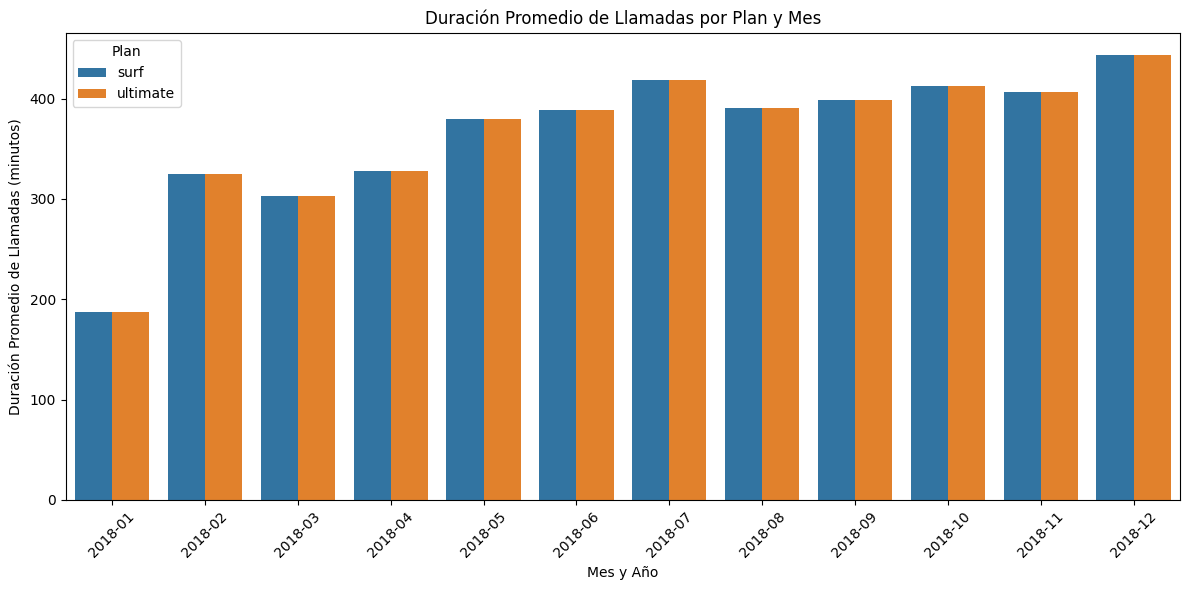

In [34]:
# Comparar la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.

avg_call_duration = df_prices.groupby(['plan_name', 'year_month'])['total_minutes'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=avg_call_duration, x='year_month', y='total_minutes', hue='plan_name')

plt.xlabel('Mes y Año')
plt.ylabel('Duración Promedio de Llamadas (minutos)')
plt.title('Duración Promedio de Llamadas por Plan y Mes')
plt.xticks(rotation=45)
plt.legend(title='Plan')
plt.tight_layout()

plt.show()

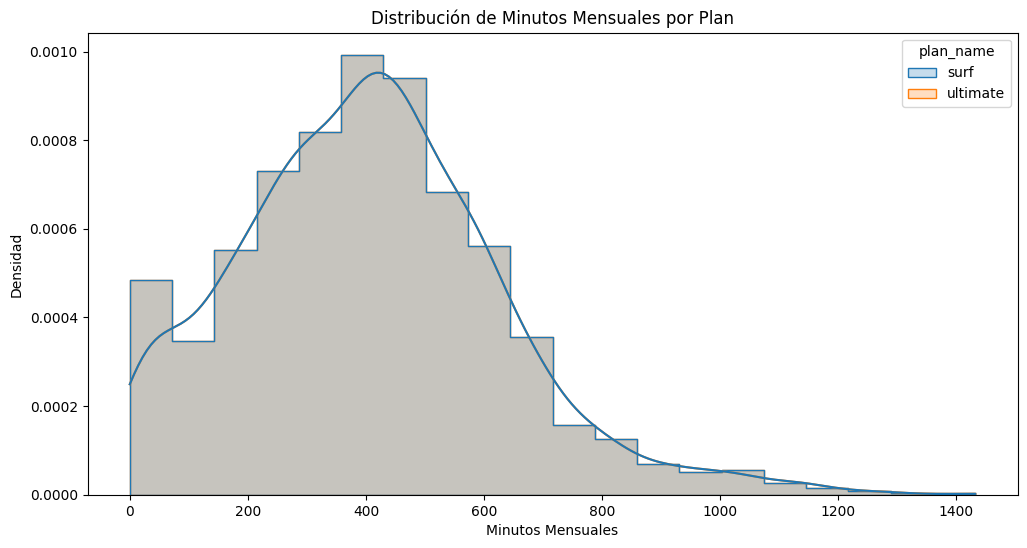

In [35]:
# Comparar el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.

plt.figure(figsize=(12, 6))

sns.histplot(data=df_prices, x='total_minutes', hue='plan_name', kde=True, bins=20, element="step", stat="density")

plt.xlabel('Minutos Mensuales')
plt.ylabel('Densidad')
plt.title('Distribución de Minutos Mensuales por Plan')



plt.show()


In [36]:
# Calcular la media y la varianza de la duración mensual de llamadas.
mean_total_minutes = df_prices['total_minutes'].mean()
var_total_minutes = df_prices['total_minutes'].var()

print( mean_total_minutes)
print( var_total_minutes)

# Media y varianza por plan
mean_var_by_plan = df_prices.groupby('plan_name')['total_minutes'].agg(['mean', 'var']).reset_index()
print("\nMedia y varianza de duración mensual de llamadas por plan:")
print(mean_var_by_plan)

405.70606192760573
49897.06865244894

Media y varianza de duración mensual de llamadas por plan:
  plan_name        mean           var
0      surf  405.706062  49907.953702
1  ultimate  405.706062  49907.953702


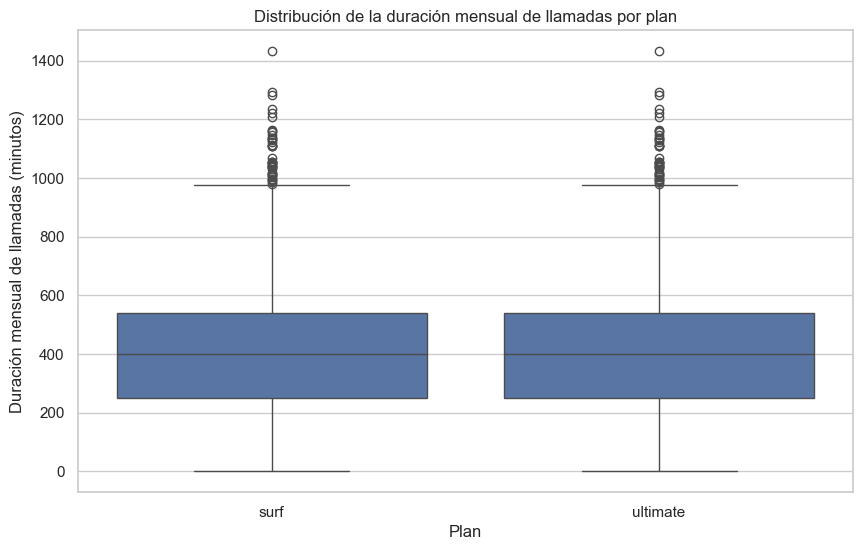

In [37]:
# Trazar un diagrama de caja para visualizar la distribución de la duración mensual de llamadas

sns.set(style="whitegrid")


plt.figure(figsize=(10, 6))
sns.boxplot(x='plan_name', y='total_minutes', data=df_prices)

plt.xlabel('Plan')
plt.ylabel('Duración mensual de llamadas (minutos)')
plt.title('Distribución de la duración mensual de llamadas por plan')
plt.show()

Conclusion: 

Sin importar el plan en el que un cliente este suscrito la duracion de las llamadas es la misma.

### Mensajes

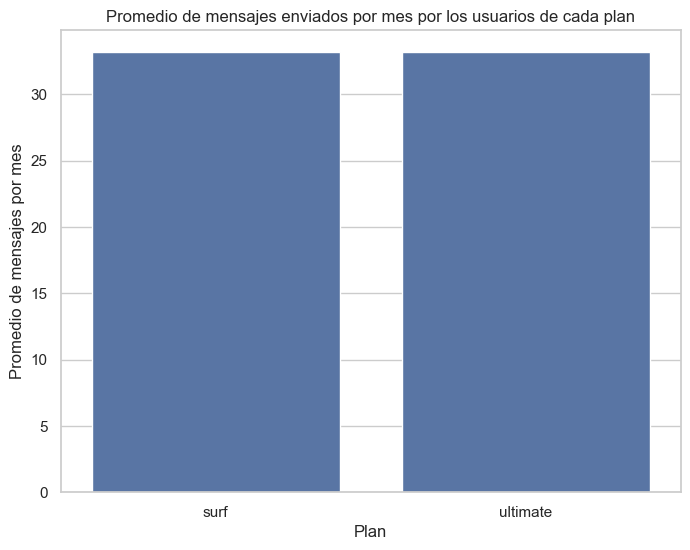

In [38]:
# Comparar el número de mensajes que tienden a enviar cada mes los usuarios de cada plan

average_messages_per_month = df_prices.groupby('plan_name')['message_count'].mean()

plt.figure(figsize=(8, 6))
sns.barplot(x=average_messages_per_month.index, y=average_messages_per_month.values)

plt.xlabel('Plan')
plt.ylabel('Promedio de mensajes por mes')
plt.title('Promedio de mensajes enviados por mes por los usuarios de cada plan')
plt.show()


In [39]:
# Calcular la media y la varianza del numero mensual de mensajes.

mean_messages = df_prices['message_count'].mean()
var_messages = df_prices['message_count'].var()

print( mean_messages)
print( var_messages)

# Media y varianza por plan
mensajes_plan = df_prices.groupby('plan_name')['message_count'].agg(['mean', 'var']).reset_index()
print("\nMedia y varianza de los mensajes mensuales por plan:")
print(mensajes_plan)

33.166593981683384
1160.517496662594

Media y varianza de los mensajes mensuales por plan:
  plan_name       mean          var
0      surf  33.166594  1160.770664
1  ultimate  33.166594  1160.770664


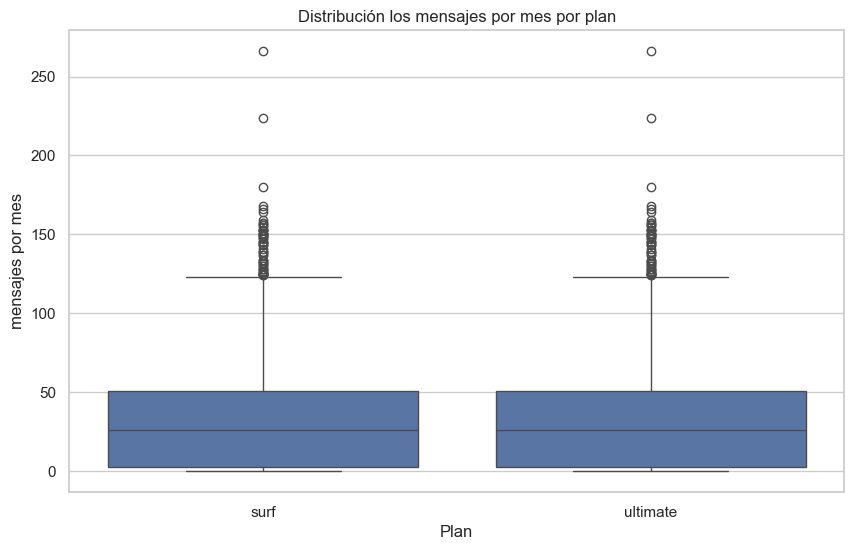

In [40]:
# Trazar un diagrama de caja para visualizar la distribución de los mensajes por mes

sns.set(style="whitegrid")


plt.figure(figsize=(10, 6))
sns.boxplot(x='plan_name', y='message_count', data=df_prices)

plt.xlabel('Plan')
plt.ylabel('mensajes por mes')
plt.title('Distribución los mensajes por mes por plan')
plt.show()

Conclusion:
El numero de mensajes que envian los usuarios es el mismo en ambos planes

### Internet

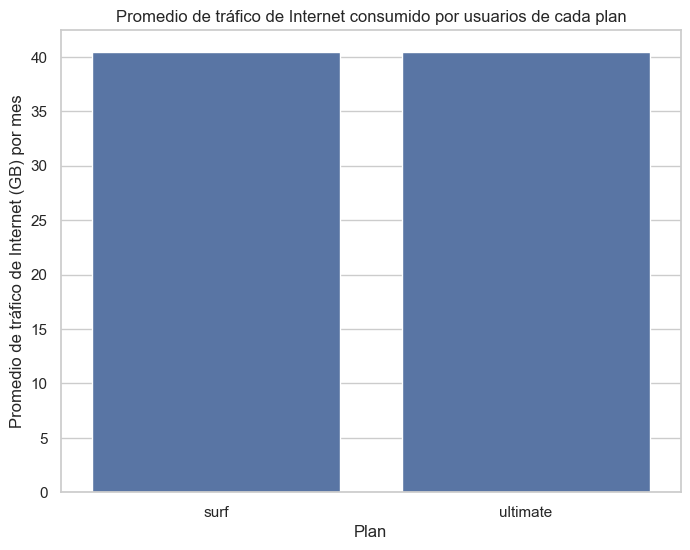

In [41]:
# Comparar la cantidad de tráfico de Internet consumido por usuarios por plan

average_data_per_plan = df_prices.groupby('plan_name')['gb_per_month'].mean()


plt.figure(figsize=(8, 6))
sns.barplot(x=average_data_per_plan.index, y=average_data_per_plan.values)


plt.xlabel('Plan')
plt.ylabel('Promedio de tráfico de Internet (GB) por mes')
plt.title('Promedio de tráfico de Internet consumido por usuarios de cada plan')
plt.show()



In [42]:
# Calcular la media y la varianza del internet mensual.

mean_gb = df_prices['gb_per_month'].mean()
var_gb = df_prices['gb_per_month'].var()

print( mean_gb)
print( var_gb)

# Media y varianza por plan
internet_plan = df_prices.groupby('plan_name')['gb_per_month'].agg(['mean', 'var']).reset_index()
print("\nMedia y varianza del interet mensual por plan:")
print(internet_plan)

40.435673789795025
304.1586747585583

Media y varianza del interet mensual por plan:
  plan_name       mean         var
0      surf  40.435674  304.225027
1  ultimate  40.435674  304.225027


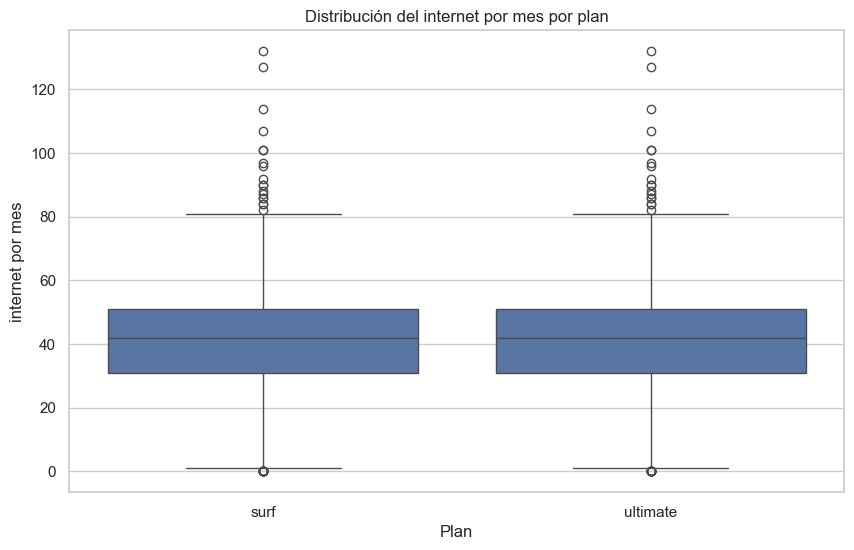

In [43]:
# Trazar un diagrama de caja para visualizar la distribución del internet por mes

sns.set(style="whitegrid")


plt.figure(figsize=(10, 6))
sns.boxplot(x='plan_name', y='gb_per_month', data=df_prices)

plt.xlabel('Plan')
plt.ylabel('internet por mes')
plt.title('Distribución del internet por mes por plan')
plt.show()

Conclusion: 
Los usuarios de ambos planes utilizan el mismo numero de Gb de internet

## Ingreso

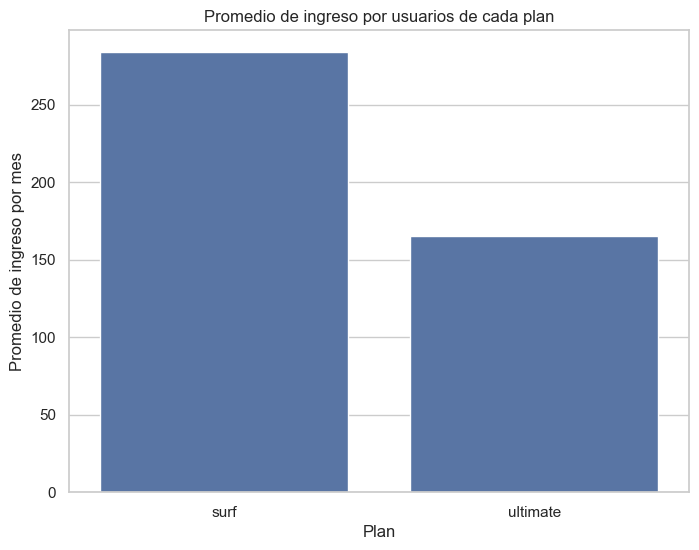

In [44]:
# Comparar la cantidad de ingreso por usuarios por plan

money_per_plan = df_cost.groupby('plan_name')['mensual_pay'].mean()


plt.figure(figsize=(8, 6))
sns.barplot(x=money_per_plan.index, y=money_per_plan.values)


plt.xlabel('Plan')
plt.ylabel('Promedio de ingreso por mes')
plt.title('Promedio de ingreso por usuarios de cada plan')
plt.show()




In [45]:
# Calcular la media y la varianza del ingreso mensual.

mean_ingreso = df_cost['mensual_pay'].mean()
var_ingreso = df_cost['mensual_pay'].var()

print( mean_ingreso)
print( var_ingreso)

# Media y varianza por plan
ingreso_plan = df_prices.groupby('plan_name')['gb_per_month'].agg(['mean', 'var']).reset_index()
print("\nMedia y varianza del ingreso mensual por plan:")
print(ingreso_plan)

224.66516790231137
20400.77555749634

Media y varianza del ingreso mensual por plan:
  plan_name       mean         var
0      surf  40.435674  304.225027
1  ultimate  40.435674  304.225027


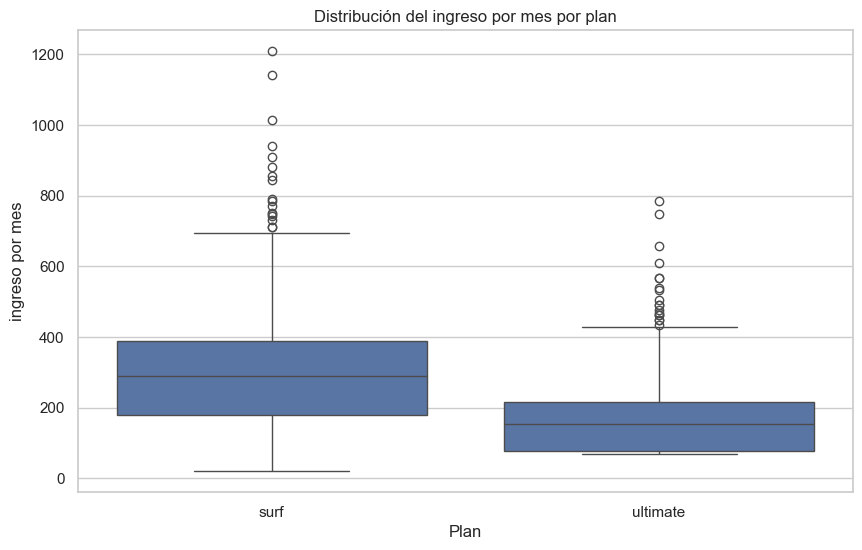

In [46]:
# Trazar un diagrama de caja para visualizar la distribución del ingreso por mes

sns.set(style="whitegrid")


plt.figure(figsize=(10, 6))
sns.boxplot(x='plan_name', y='mensual_pay', data=df_cost)

plt.xlabel('Plan')
plt.ylabel('ingreso por mes')
plt.title('Distribución del ingreso por mes por plan')
plt.show()

In [47]:
# Comprobar el numero de usuarios de cada plan

print(df_cost.shape[0])
print(df_cost[df_cost['plan_name']== 'surf'].shape[0])
print(df_cost[df_cost['plan_name']== 'ultimate'].shape[0])

4586
2293
2293


Conclusion:
Una vez comprobando que ambos planes tienen el mismo numero de usuarios pude concluir que:
A pesar de que el plan ultimate es el mas caro, el plan surf tiene mas ingresos, esto se debe a que los usuarios del plan surf rebasan los rangos incluidos en sus servicios y terminan pagando los costos extra.

## Prueba de las hipótesis estadísticas

### Primera Hipotesis

Hipótesis Nula: Los ingresos promedio de los usuarios de los planes Ultimate y Surf son iguales.

Hipótesis Alternativa: Los ingresos promedio de los usuarios de los planes Ultimate y Surf son diferentes.

Alfa:0.05

In [48]:
# Prueba de las hipótesis
from scipy import stats as st

surf = df_cost[df_cost['plan_name']== 'surf']['mensual_pay']
ultimate = df_cost[df_cost['plan_name']== 'ultimate']['mensual_pay']

alpha = 0.05


results = st.ttest_ind(surf, ultimate) # realizar una prueba

print('valor p: ', results.pvalue) # extraer el valor p

if results.pvalue < alpha: # comparar el valor p con el umbral
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")

valor p:  2.0195180116907488e-189
Rechazamos la hipótesis nula


### Segunda Hipotesis

Hipótesis Nula: El ingreso promedio de los usuarios del área NY-NJ es igual al de los usuarios de otras regiones.

Hipótesis Alternativa: El ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones.

Alfa:0.05

In [49]:
# Mostrar informacion de la tabla
df_cost.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4586 entries, 0 to 4585
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype    
---  ------               --------------  -----    
 0   user_id              4586 non-null   int64    
 1   plan_name            4586 non-null   object   
 2   year_month           4586 non-null   period[M]
 3   extra_minutes_cost   4586 non-null   float64  
 4   extra_messages_cost  4586 non-null   float64  
 5   extra_data_cost      4586 non-null   float64  
 6   mensual_pay          4586 non-null   float64  
dtypes: float64(4), int64(1), object(1), period[M](1)
memory usage: 286.6+ KB


In [50]:
#Agregar a df_users la columna de los pagos mensuales

df_hyp = pd.merge(df_users, df_cost, on='user_id', how='left')
df_hyp = df_hyp.dropna(subset=['mensual_pay'])


In [51]:
# Calcular la media de los ingresos de NY-NJ y la de las demas ciudades
nynj = df_hyp[df_hyp['city'] == 'New York-Newark-Jersey City, NY-NJ-PA MSA']

other_citys = df_hyp[df_hyp['city'] != 'New York-Newark-Jersey City, NY-NJ-PA MSA']

print(nynj['mensual_pay'].mean())
print(other_citys['mensual_pay'].mean())

225.50441644562338
224.50003392484345


In [52]:
# Prueba de las hipótesis
from scipy import stats as st

nynj_pays = nynj['mensual_pay']

other_citys_pays = other_citys['mensual_pay']

alpha = 0.05


results = st.ttest_ind(nynj_pays, other_citys_pays) # realizar una prueba

print('valor p: ', results.pvalue) # extraer el valor p

if results.pvalue < alpha: # comparar el valor p con el umbral
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")


valor p:  0.8599196060193487
No podemos rechazar la hipótesis nula


## Conclusión general


En general, este análisis proporcionó información valiosa sobre los patrones de consumo y cómo los diferentes planes afectan los ingresos de la compañía. También mostró la importancia de entender el comportamiento de los usuarios en relación con los costos adicionales, lo que puede ayudar a mejorar la oferta de servicios y la estrategia de precios. Lo mas notorio fue que la compañia podría ganar mas con el plan surf, ya que los usuarios rebasan la tarifa y tendrían que pagar costos extras